In [117]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from time import perf_counter
import xgboost as xgb
sns.set()

In [89]:
us_mask = pd.DataFrame(pd.read_hdf('~/Desktop/Research/data/SSF/us_mask.h5'))
# previous lat/lon = 25.25, 279.25
tar_lat = 33.75
tar_lon = 242.25
# This block is to put all nearby sst data together in time order
# And also transform data into time order (single location\)
y_samp = pd.Series()
X_total = []
for i in range(2014,2019):
    print('precip.'+str(i)+'.h5')
    name_precip = 'precip.'+str(i)+'.h5'
    name_sst = 'sst.'+str(i)+'.h5' 
    name_hgt = 'hgt500.'+str(i)+'.h5'
    name_rhum = 'rhum.sig995.'+str(i)+'.h5'
    name_tmp2m = 'tmp2m.'+str(i)+'.h5'
    fileloc_precip = '~/Desktop/Research/data/SSF/' + name_precip
    fileloc_sst = '~/Desktop/Research/data/SSF/' + name_sst
    fileloc_hgt = '~/Desktop/Research/data/SSF/' + name_hgt
    fileloc_rhum = '~/Desktop/Research/data/SSF/' + name_rhum
    fileloc_tmp2m = '~/Desktop/Research/data/SSF/' + name_tmp2m
    precip = pd.DataFrame(pd.read_hdf(fileloc_precip)).reset_index()
    precip.columns = ['lat', 'lon', 'start_date', 'precip']
    sst = pd.DataFrame(pd.read_hdf(fileloc_sst)).reset_index()
    sst.columns = ['lat', 'lon', 'start_date', 'sst']
    hgt = pd.DataFrame(pd.read_hdf(fileloc_hgt)).reset_index()
    hgt.columns = ['lat', 'lon', 'start_date', 'hgt']
    rhum = pd.DataFrame(pd.read_hdf(fileloc_rhum)).reset_index()
    rhum.columns = ['lat', 'lon', 'start_date', 'rhum']
    tmp2m = pd.DataFrame(pd.read_hdf(fileloc_tmp2m)).reset_index()
    tmp2m.columns = ['lat', 'lon', 'start_date', 'tmp2m']
    
    precip = pd.merge(precip, us_mask, on=['lat','lon'])
    hgt = pd.merge(hgt, us_mask, on=['lat','lon'])
    rhum = pd.merge(rhum, us_mask, on=['lat','lon'])
    tmp2m = pd.merge(tmp2m, us_mask, on=['lat','lon'])
    
    hgt = np.reshape(hgt[(hgt['lat']==tar_lat) & (hgt['lon']==tar_lon)].hgt.to_numpy(),(-1,1))
    rhum = np.reshape(rhum[(rhum['lat']==tar_lat) & (rhum['lon']==tar_lon)].rhum.to_numpy(),(-1,1))
    tmp2m = np.reshape(tmp2m[(tmp2m['lat']==tar_lat) & (tmp2m['lon']==tar_lon)].tmp2m.to_numpy(),(-1,1))
    
    y_samp = y_samp.append(precip[(precip['lat']==tar_lat) & (precip['lon']==tar_lon)].precip,ignore_index=True)
    
    if i%4 == 0:
        days = 366
    else:
        days = 365
    temp = sst[(sst['lat']>=tar_lat-1) & (sst['lat']<=tar_lat+1) & (sst['lon']>=tar_lon-1) & (sst['lon']<=tar_lon+1)]
    sst_samp = temp.sst.reset_index().sst.to_numpy()
    size = int(len(sst_samp)/days)
    sst_samp = np.reshape(sst_samp,(size,days)).transpose() # days as rows, different locations as columns
    all_features = np.concatenate((sst_samp,hgt,rhum,tmp2m),axis=1)
    X_total.append(all_features)
    
X_size = X_total[0].shape[1]
X_samp = np.zeros((1,X_size)) #  For concatenating all data
for i in range(len(X_total)):
    X_samp = np.concatenate((X_samp,X_total[i]),axis = 0)
X_samp = X_samp[1:]

<ipython-input-89-2b5b6646e4be>:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_samp = pd.Series()


precip.2014.h5
precip.2015.h5
precip.2016.h5
precip.2017.h5
precip.2018.h5


In [65]:
np.set_printoptions(suppress=True)
print(np.sort(precip['lat'].unique()))
print(np.sort(precip['lon'].unique()))
print(np.sort(sst['lat'].unique()))
print(np.sort(sst['lon'].unique()))

[25.25 25.75 26.25 26.75 27.25 27.75 28.25 28.75 29.25 29.75 30.25 30.75
 31.25 31.75 32.25 32.75 33.25 33.75 34.25 34.75 35.25 35.75 36.25 36.75
 37.25 37.75 38.25 38.75 39.25 39.75 40.25 40.75 41.25 41.75 42.25 42.75
 43.25 43.75 44.25 44.75 45.25 45.75 46.25 46.75 47.25 47.75 48.25 48.75]
[235.75 236.25 236.75 237.25 237.75 238.25 238.75 239.25 239.75 240.25
 240.75 241.25 241.75 242.25 242.75 243.25 243.75 244.25 244.75 245.25
 245.75 246.25 246.75 247.25 247.75 248.25 248.75 249.25 249.75 250.25
 250.75 251.25 251.75 252.25 252.75 253.25 253.75 254.25 254.75 255.25
 255.75 256.25 256.75 257.25 257.75 258.25 258.75 259.25 259.75 260.25
 260.75 261.25 261.75 262.25 262.75 263.25 263.75 264.25 264.75 265.25
 265.75 266.25 266.75 267.25 267.75 268.25 268.75 269.25 269.75 270.25
 270.75 271.25 271.75 272.25 272.75 273.25 273.75 274.25 274.75 275.25
 275.75 276.25 276.75 277.25 277.75 278.25 278.75 279.25 279.75 280.25
 280.75 281.25 281.75 282.25 282.75 283.25 283.75 284.25 284.75 285.

In [81]:
precip[(precip['lat']==33.75) & (precip['lon']==242.25)]
sst[(sst['lat']==33.75) & (sst['lon']==242.75)]

,lat,lon,start_date,sst


In [90]:
X_copy = X_samp.copy()
y_copy = y_samp.to_numpy().copy()

In [100]:
X_copy.shape
sst_size = X_copy.shape[1]-3

In [92]:
X_samp = X_copy.copy()
y_samp = y_copy.copy()
target = 'precip'

In [93]:
# This block is to switch target y from precipitation to tmp2m
y_samp = X_copy[:,X_copy.shape[1]-1].copy()
X_samp[:,X_copy.shape[1]-1] = y_copy.copy()
target = 'tmp2m'

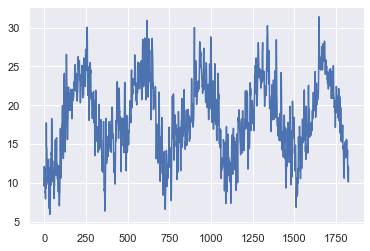

In [94]:
plt.plot(y_samp)

In [95]:
# Calculate moving average for precip
avg_window = 14
y_movavg = []
X_movavg = []
for i in range(y_samp.shape[0]-avg_window):
    y_avg = np.mean(y_samp[i:i+avg_window])
    y_movavg.append(y_avg)
    X_avg = np.mean(X_samp[i:i+avg_window],axis=0)
    X_movavg.append(X_avg)
y_movavg = np.array(y_movavg)
X_movavg = np.array(X_movavg)
y_samp = y_movavg
X_samp = X_movavg

In [102]:
# Standardize data by z-scoring
mean = np.mean(y_samp)
std = np.std(y_samp)
y_samp = (y_samp-mean)/std
X_samp[:,0:sst_size] = (X_samp[:,0:sst_size] - np.mean(X_samp[:,0:sst_size]))/np.std(X_samp[:,0:sst_size])
X_samp[:,sst_size] = (X_samp[:,sst_size] - np.mean(X_samp[:,sst_size]))/np.std(X_samp[:,sst_size])
X_samp[:,sst_size+1] = (X_samp[:,sst_size+1] - np.mean(X_samp[:,sst_size+1]))/np.std(X_samp[:,sst_size+1])
X_samp[:,sst_size+2] = (X_samp[:,sst_size+2] - np.mean(X_samp[:,sst_size+2]))/np.std(X_samp[:,sst_size+2])

X = X_samp.copy()
y = y_samp.copy()




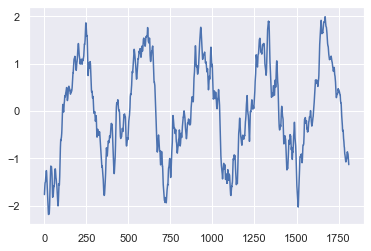

In [103]:
plt.plot(y_samp)

In [10]:
# # Standardize data by taking logarithm
# y_samp = y_samp.to_numpy()
# y_samp = np.log(y_samp+1)
# X_samp = np.log(X_samp)
# X = X_samp.copy()
# y = y_samp.copy()

In [104]:
def create_sequence(input_data, train_window,pred_window):  #  Create sequences of observations for training
    seq = []
    L = len(input_data)
    feature_size = input_data[0].shape[0]
    for i in range(L-train_window-pred_window):
        train_seq = input_data[i:i+train_window]
        train_label = input_data[i+train_window+pred_window-1,feature_size-1] # get y_t+14
        seq.append((train_seq ,train_label))
    return seq

In [105]:
train_test_split = 0.8
test_size = int((1-train_test_split)*y_samp.shape[0])
X_train = X[:-test_size]
X_test = X[-test_size:]
y_train = y[:-test_size]
y_test = y[-test_size:]


In [106]:
y_train = np.reshape(y_train,(-1,1))  #  Matching dimension for concatenating X and y
y_test = np.reshape(y_test,(-1,1)) 
train_data_array = np.concatenate((X_train,y_train),axis=1)
train_data = torch.FloatTensor(train_data_array)
y_train = torch.FloatTensor(y_train)

In [107]:
train_data.shape

torch.Size([1450, 11])

In [108]:
device = torch.device("cuda:0")
train_data = train_data.to(device)
y_train = y_train.to(device)

In [109]:
train_window = 90
pred_window = 28
train_seq = create_sequence(train_data,train_window,pred_window)

In [110]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, num_layers=1, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(num_layers,1,self.hidden_layer_size),
                            torch.zeros(num_layers,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [111]:
model = LSTM(input_size=X_size+1, hidden_layer_size=100, num_layers=1, output_size=1).to(device) # 2 features from X_obs and 1 from y_obs
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [112]:
print(model)

LSTM(
  (lstm): LSTM(11, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [113]:
epochs = 100
#  Training the model
t0 = perf_counter()

for i in range(epochs):
    for seq, labels in train_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(model.num_layers, 1, model.hidden_layer_size).to(device),
                        torch.zeros(model.num_layers, 1, model.hidden_layer_size).to(device))

        pred = model(seq)
        labels = torch.reshape(labels,(-1,))  #  Match size to avoid warning
        single_loss = loss_function(pred, labels)
        single_loss.backward()
        optimizer.step()
    
   
                
    if i%10 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
#     print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
    
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
t1 = perf_counter()
train_time = t1 - t0
print(f'Total training time: {train_time}')

epoch:   1 loss: 0.15086448
epoch:  11 loss: 0.00737573
epoch:  21 loss: 0.02535218
epoch:  31 loss: 0.00093528
epoch:  41 loss: 0.02829931
epoch:  51 loss: 0.01092113
epoch:  61 loss: 0.00117844
epoch:  71 loss: 0.00500207
epoch:  81 loss: 0.00014144
epoch:  91 loss: 0.03183883
epoch:  99 loss: 0.0185706634
Total training time: 388.83195550000164


In [114]:
# Predicting t+1
test_data = np.concatenate((X_test,y_test),axis=1)

train_test_total = np.concatenate((train_data_array,test_data))

model.eval()
num_pred = 1 #  Number of prediction forward, i.e. tau
res = np.zeros(train_window).tolist()
#  Predicting y using X_test and y_test
for i in range(train_test_total.shape[0]-train_window):
    for j in range(num_pred):
        seq = torch.FloatTensor(train_test_total[i:i+train_window]).to(device)
        #print(seq)
        with torch.no_grad():
            model.hidden = (torch.zeros(model.num_layers, 1, model.hidden_layer_size).to(device),
                            torch.zeros(model.num_layers, 1, model.hidden_layer_size).to(device))
            #print(model(seq))
            pred = model(seq).cpu()
            #print(len(test_inputs))
            res.append(pred)
res = np.array(res)

In [ ]:
# Predicting t+tau
test_data = np.concatenate((X_test,y_test),axis=1) 
train_test_total = np.concatenate((train_data_array,test_data))

model.eval()
num_pred = 1 #  Number of prediction forward, i.e. tau
res = np.zeros(train_window).tolist()
#  Predicting y using X_test and y_test
for i in range(train_test_total.shape[0]-train_window):
    for j in range(num_pred):
        seq = torch.FloatTensor(train_test_total[i:i+train_window])
        #print(seq)
        with torch.no_grad():
            model.hidden = (torch.zeros(model.num_layers, 1, model.hidden_layer_size),
                            torch.zeros(model.num_layers, 1, model.hidden_layer_size))
            #print(model(seq))
            pred = model(seq)
            #print(len(test_inputs))
            res.append(pred)

            

array([0.0, 0.0, 0.0, ..., tensor([0.3381], device='cuda:0'),
       tensor([0.3555], device='cuda:0'),
       tensor([0.4765], device='cuda:0')], dtype=object)

r-sq on train: 0.6120868988630799
r-sq on test: 0.591112255964871
cosine_similarity on train: [[0.78573143]]
cosine_similarity on test: [[0.77760496]]


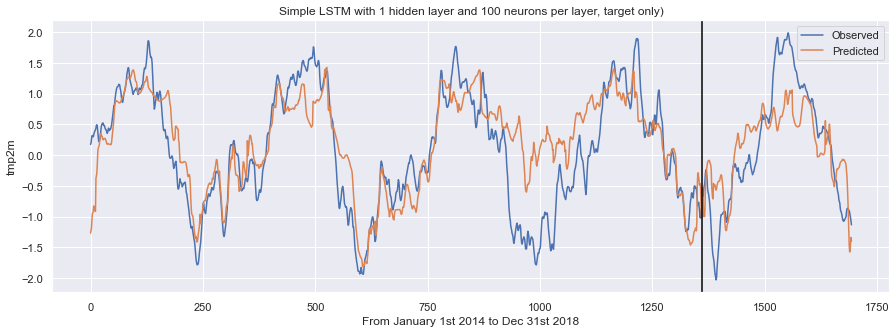

In [115]:
y_train = y_train.cpu()
y_train_true = y_samp[train_window+pred_window:-test_size]
y_train_pred = res[train_window:-test_size-pred_window]
y_test_true = y_samp[-test_size:]
y_test_pred = res[-test_size-pred_window:-pred_window]
print('r-sq on train:', r2_score(y_train_true, y_train_pred))
print('r-sq on test:', r2_score(y_test_true,  y_test_pred))
plt.figure(figsize=(15,5))
plt.plot(y_samp[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 2014 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Simple LSTM with 1 hidden layer and 100 neurons per layer, target only)')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black')
print('cosine_similarity on train:', cosine_similarity(y_train_true.reshape((1,-1)), y_train_pred.reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_test_true.reshape((1,-1)),  y_test_pred.reshape((1,-1))))

In [29]:
y_train_true.reshape((-1,1)).shape

(1392, 1)

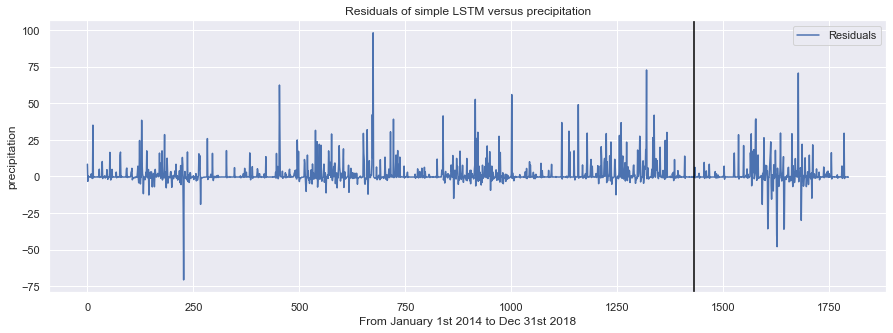

In [28]:
plt.figure(figsize=(15,5))
plt.plot(y_samp[train_window:] - res[train_window:] ,label='Residuals')
plt.legend()
plt.xlabel('From January 1st 2014 to Dec 31st 2018')
plt.ylabel('precipitation')
plt.title('Residuals of simple LSTM versus precipitation')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black')

In [54]:
np.sum((np.array(res[train_size:]) - y_test[:,0]) ** 2)/y_test.shape[0]  # MSE


tensor([0.6813], device='cuda:0')

In [429]:
tmp2m = pd.DataFrame(pd.read_hdf('SSF/tmp2m.2018.h5')).reset_index()


In [432]:
test = tmp2m[(tmp2m['lat']==25.25) & (tmp2m['lon']==279.25)]
test

,lat,lon,start_date,0
8108021,25.25,279.25,2018-01-01,20.244444
8108022,25.25,279.25,2018-01-02,17.381365
8108023,25.25,279.25,2018-01-03,15.314527
8108024,25.25,279.25,2018-01-04,10.294666
8108025,25.25,279.25,2018-01-05,11.791142
...,...,...,...,...
8108381,25.25,279.25,2018-12-27,24.758492
8108382,25.25,279.25,2018-12-28,25.610886
8108383,25.25,279.25,2018-12-29,24.864708
8108384,25.25,279.25,2018-12-30,23.908970


In [15]:
import pyflux as pf
test = pd.DataFrame(y_samp).astype('double')
model_VAR = pf.VAR(data=test,lags=7,integ=1)